TANZANIA'S WATER PUMPS MAINTENANCE PREDICTION

The goal of this project is to provide a tool for predictive maintenance of water pumps in Tanzania. Tipically, the data set at the core of this work has been used in classification problems. Here, survival regression and other algorithms are compared with the goal of suggesting maintenance even before a water pump breaks down. The probability and risk of breaking down can be used for this purpose.
The data set used in this project is available from different resources. It has been posted on DrivenData and Kaggle:

https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/

https://www.kaggle.com/c/ds1-predictive-modeling-challenge/overview

It is also available for direct download:

https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv (features)

https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv (labels)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as scs
import itertools

from collections import defaultdict

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.svm import FastSurvivalSVM
from sksurv.ensemble import RandomSurvivalForest

from sklearn.preprocessing import LabelEncoder

import pickle

import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
# Import custom modules
import src.utils.infodf as idf
import src.utils.catwran as cw
import src.utils.numwran as nw
import src.models.surv_comp as su

In [24]:
# Seaborn plots settings
bcol=sns.color_palette('colorblind').as_hex()
sns.set_palette("colorblind")
sns.set(style='whitegrid')

DOWNLOAD DATA

In [26]:
#dfXd=pd.read_csv('https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv')
#dfyd=pd.read_csv('https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv')

# previously downloaded from the above links
dfX=pd.read_csv('data/raw/features.csv')
dfy=pd.read_csv('data/raw/labels.csv')

In [27]:
dfX.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe


In [28]:
dfy.head(3)

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional


DATA WRANGLING

In [29]:
print('Number of observations: ', dfX.shape[0])
print('Number of attributes: ', dfX.shape[1])
print('Same Id:', dfX['id'].equals(dfy['id']))

Number of observations:  59400
Number of attributes:  40
Same Id: True


Each row is a water pump, identified by a number. This information is dropped after merging the dataframes.

In [30]:
# The same can be done using the concat function
dfall=pd.merge(dfX,dfy,on='id')
dfId=dfall[['id']]
dfall.drop(['id'],axis=1,inplace=True)
dfall.shape[0]

59400

In [31]:
dfall['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

"Status_group" indicates the functionality of the water pumps, and would be the target variable if a multi-class classifier were to be built. One class has much less observations. Here a model for predictive maintenance will be built, and the "non functional" and "functional needs repair" classes will be combined. In fact, the purpose is to be able to give useful information to organize maintenance before a water pumps breaks.

In [32]:
# check for duplicates
dupl=dfall[dfall.duplicated()]
dupl.shape

(36, 40)

In [33]:
dfall.drop_duplicates(inplace=True)
dfall.reset_index(drop=True,inplace=True)
dfall.shape

(59364, 40)

Some custom functions are used to help with analyzing the data and clean it. The first one prints out information on the attribute types and if any values are missing.

In [34]:
all_types=idf.dataFr_info(dfall)

Percentage of missing values in funder: 7.4
Percentage of missing values in installer: 7.5
Percentage of missing values in wpt_name: 6.0
Percentage of missing values in subvillage: 0.6
Percentage of missing values in public_meeting: 5.6
Percentage of missing values in scheme_management: 6.5
Percentage of missing values in scheme_name: 47.4
Percentage of missing values in permit: 5.1


Number of columns of float64 type: 3 
 ['amount_tsh', 'longitude', 'latitude'] 

Number of columns of str type: 29 
 ['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'recorded_by', 'scheme_management', 'scheme_name', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'status_group'] 

Number of columns of int64 type: 6 
 ['gps_hei

There are 40 attributes of various type. Some may contain redundant information. Also, some values are missing in the categorical variables columns. One of them, "scheme_name", has almost 50% of data missing, so it will be dropped.
The different types of attribute are dealt with separately.

To start with, the recorded year is extracted from "date_recorded". This is the time when the observation was recorded, and it will be used together with the "construction_year" to determine the age of a pump. The age will be the timeline for the survival regression model developed later on.

In [35]:
# only the year of observation is kept and it shouldn't be of object type
dfall['recorded_year'] = pd.DatetimeIndex(dfall['date_recorded']).year
dfall.drop(['date_recorded'],axis=1,inplace=True)

Before doing any encoding of categories and analyzing correlations, columns that don't have useful information because their value is unique or they have too many missing data are dropped.

In [36]:
df=idf.drop_columns(dfall)

Number of columns before drop: 40
Number of columns after drop: 32
Dropped columns: ['num_private', 'public_meeting', 'recorded_by', 'scheme_name', 'management_group', 'water_quality', 'quality_group', 'source_class']


In [37]:
# check changes
new_types=idf.dataFr_info(df)

Percentage of missing values in funder: 7.4
Percentage of missing values in installer: 7.5
Percentage of missing values in wpt_name: 6.0
Percentage of missing values in subvillage: 0.6
Percentage of missing values in scheme_management: 6.5
Percentage of missing values in permit: 5.1


Number of columns of float64 type: 3 
 ['amount_tsh', 'longitude', 'latitude'] 

Number of columns of str type: 22 
 ['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'scheme_management', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'payment', 'payment_type', 'quantity', 'quantity_group', 'source', 'source_type', 'waterpoint_type', 'waterpoint_type_group', 'status_group'] 

Number of columns of int64 type: 6 
 ['gps_height', 'region_code', 'district_code', 'population', 'construction_year', 'recorded_year'] 

Number of columns of bool type: 1 
 ['permit'] 



Boolean variables

In [38]:
df_bool=df[['permit']].copy()
df_bool_enc=cw.encode_bool(df_bool)

Categorical variables

By the name of the attributes and their description available on some of the links, it's possible that they represent the same type of information. To confirm that, correlation between categorical variables is looked into. Before that, those that have missing values are filled in as "unknown". Also, for the purpose of encoding, if the number of levels is higher then a certain threshold, only the top values in terms of frequency are kept, while the others are all grouped under "other".

In [39]:
def count_cat(dataFr,cols):
    
    '''print number of levels for each categorical variable'''
    
    for col in cols: print(col,len(dataFr[col].unique()))

In [40]:
count_cat(dfall,new_types['str'])

funder 1898
installer 2146
wpt_name 37400
basin 9
subvillage 19288
region 21
lga 125
ward 2092
scheme_management 13
extraction_type 18
extraction_type_group 13
extraction_type_class 7
management 12
payment 7
payment_type 7
quantity 5
quantity_group 5
source 10
source_type 7
waterpoint_type 7
waterpoint_type_group 6
status_group 3


A couple of attributes, "subvillage" and "wpt_name" have a very high number of possible values. The former contains geographical information, which can also be derived from other attributes. The latter is the name of the water point, according to the documentation available. Instead of encoding these attributes, even after grouping them, they are dropped.

In [41]:
df.drop(['subvillage','wpt_name'],axis=1,inplace=True)
new_types=idf.dataFr_info(df)

Percentage of missing values in funder: 7.4
Percentage of missing values in installer: 7.5
Percentage of missing values in scheme_management: 6.5
Percentage of missing values in permit: 5.1


Number of columns of float64 type: 3 
 ['amount_tsh', 'longitude', 'latitude'] 

Number of columns of str type: 20 
 ['funder', 'installer', 'basin', 'region', 'lga', 'ward', 'scheme_management', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'payment', 'payment_type', 'quantity', 'quantity_group', 'source', 'source_type', 'waterpoint_type', 'waterpoint_type_group', 'status_group'] 

Number of columns of int64 type: 6 
 ['gps_height', 'region_code', 'district_code', 'population', 'construction_year', 'recorded_year'] 

Number of columns of bool type: 1 
 ['permit'] 



The number of levels that are kept is chosen to be 21, which is also the number of regions. This attribute is believed to be relevant and it will also be used later on to gain some insights. With this choice, all the levels of many attributes will be kept as well, except for a couple of them.
The next two functions fill any missing value of a categorical attribute with the word "unknown" and reduce the number of possible values to 21 (this threshold can also be changed).

In [42]:
df_str=df[new_types['str']].copy()
for col in df_str.columns: 
    cw.fill_missing(df_str[col])   
    df_str[col]=cw.reduce_cat(df_str[col],num=21)

['Government Of Tanzania', 'unknown', 'Danida', 'Hesawa', 'Rwssp', 'World Bank', 'Kkkt', 'World Vision', 'Unicef', 'Tasaf', 'District Council', 'Dhv', 'Private Individual', 'Dwsp', 'Norad', 'Germany Republi', 'Tcrs', 'Ministry Of Water', 'Water', 'Dwe', 'Netherlands']
['DWE', 'unknown', 'Government', 'RWE', 'Commu', 'DANIDA', 'KKKT', 'Hesawa', 'TCRS', 'Central government', 'CES', 'Community', 'DANID', 'District Council', 'HESAWA', 'World vision', 'LGA', 'WEDECO', 'TASAF', 'District council', 'Gover']
['Lake Victoria', 'Pangani', 'Rufiji', 'Internal', 'Lake Tanganyika', 'Wami / Ruvu', 'Lake Nyasa', 'Ruvuma / Southern Coast', 'Lake Rukwa']
['Iringa', 'Shinyanga', 'Mbeya', 'Kilimanjaro', 'Morogoro', 'Arusha', 'Kagera', 'Mwanza', 'Kigoma', 'Ruvuma', 'Pwani', 'Tanga', 'Dodoma', 'Singida', 'Mara', 'Tabora', 'Rukwa', 'Mtwara', 'Manyara', 'Lindi', 'Dar es Salaam']
['Njombe', 'Arusha Rural', 'Moshi Rural', 'Bariadi', 'Rungwe', 'Kilosa', 'Kasulu', 'Mbozi', 'Meru', 'Bagamoyo', 'Singida Rural', 'K

Next, the categories are encoded using label encoding is used. This is to avoid creating a high number of columns/features.

In [44]:
# This function applies label encoding to all features and returns the origina and the encoded dataframes.
# Here it is used to be able to check correlations. 
df_str_enc,df_str_noenc=cw.encoder(df_str)

Correlations between the categorical features are analyzed. For this type of variables, it has been suggested to use Cramer's V statistic instead of Pearson: https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix The following functions calculate the correlations between columns of a dataframe and plot a heatmap to visualize them.

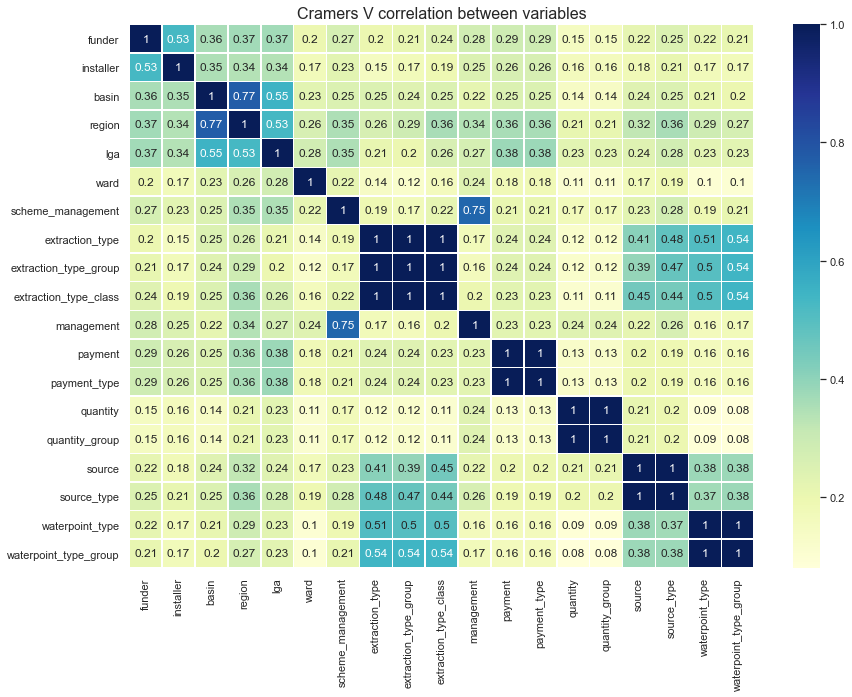

In [45]:
cw.cat_correlation(df_str_enc.drop(['status_group'],axis=1))

The correlation matrix shows that some more columns can be dropped.
Those with correlation above 0.75 are still kept, since some of them, such as region and basin, will be used for visualization and data wrangling purposes. They can be removed later on.

In [46]:
cols_to_drop=['extraction_type_group','extraction_type_class',
             'payment_type','quantity_group','source_type','waterpoint_type_group']
#For consistency, the same columns can be dropped from df_str too (dataframe which isn't encoded)
df_str_enc.drop(cols_to_drop,axis=1,inplace=True)
df_str_noenc.drop(cols_to_drop,axis=1,inplace=True)
df_str_enc.columns

Index(['funder', 'installer', 'basin', 'region', 'lga', 'ward',
       'scheme_management', 'extraction_type', 'management', 'payment',
       'quantity', 'source', 'waterpoint_type', 'status_group'],
      dtype='object')

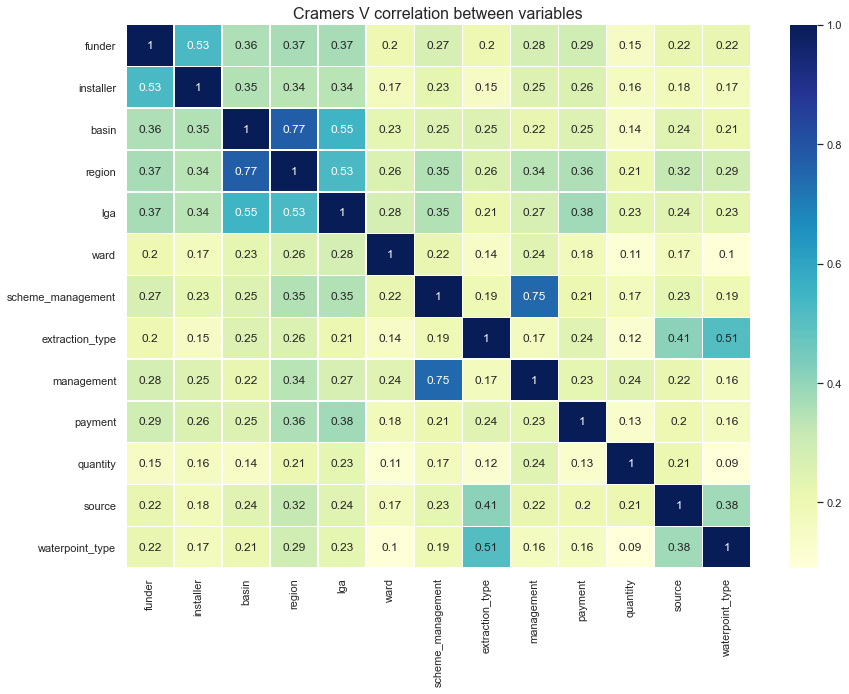

In [47]:
#check with the corrected Cramers V
cw.cat_correlation(df_str_enc.drop(['status_group'],axis=1))

If a threshold of 0.75 is considered for the correlation, another couple of columns can be dropped. For now, they are kept, also because the region may be used later.

Numerical variables

In [48]:
new_types['int64']

['gps_height',
 'region_code',
 'district_code',
 'population',
 'construction_year',
 'recorded_year']

The "region_code" and "district_code" can be checked for correlation with the other categorical variables. 

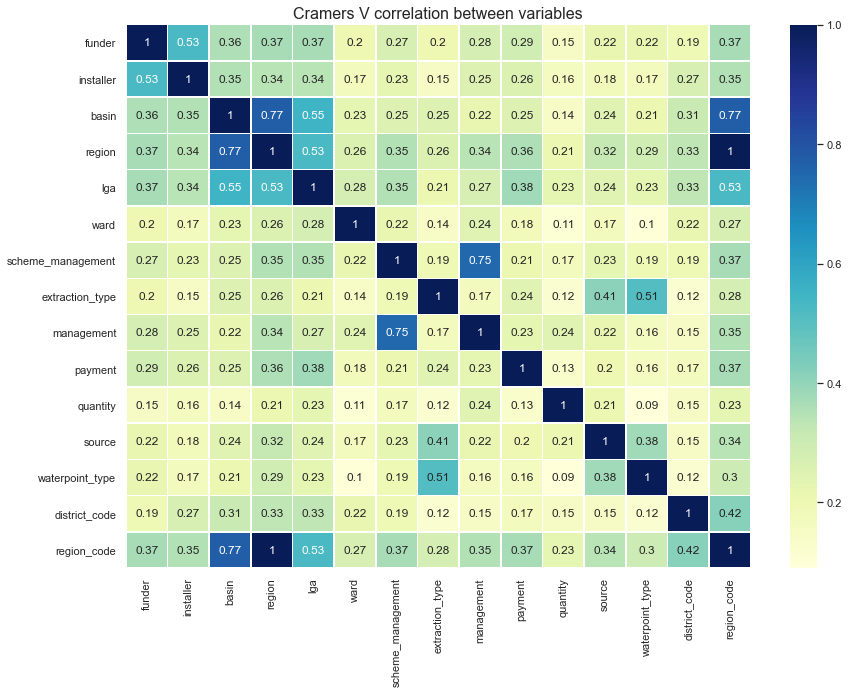

In [49]:
df_int=df[new_types['int64']].copy()
df_reg=pd.concat([df_str_enc.drop(['status_group'],axis=1),df_int[['district_code','region_code']]],axis=1)
cw.cat_correlation(df_reg)

In [50]:
# another column can be dropped
df_int.drop('region_code',axis=1,inplace=True)

Another set of custom functions is used to print out statistics about the numerical attributes.

In [51]:
stats_list=['mean','median','std','25% quantile','75% quantile']

In [52]:
df_float=df[new_types['float64']].copy()
df_num=pd.concat([df_int,df_float],axis=1)
df_num.columns

Index(['gps_height', 'district_code', 'population', 'construction_year',
       'recorded_year', 'amount_tsh', 'longitude', 'latitude'],
      dtype='object')

In [53]:
for col in df_num.columns:
    print(col)
    nw.print_stats(df_num[col])
    print('')

gps_height
Mean: 669.0 Median: 370.0  Std: 693.0  Q25: 0.0  Q75: 1320.0

district_code
Mean: 6.0 Median: 3.0  Std: 10.0  Q25: 2.0  Q75: 5.0

population
Mean: 180.0 Median: 25.0  Std: 472.0  Q25: 0.0  Q75: 215.0

construction_year
Mean: 1301.0 Median: 1986.0  Std: 951.0  Q25: 0.0  Q75: 2004.0

recorded_year
Mean: 2012.0 Median: 2012.0  Std: 1.0  Q25: 2011.0  Q75: 2013.0

amount_tsh
Mean: 318.0 Median: 0.0  Std: 2998.0  Q25: 0.0  Q75: 20.0

longitude
Mean: 34.0 Median: 34.91031805  Std: 7.0  Q25: 33.0951871375  Q75: 37.179490449999996

latitude
Mean: -6.0 Median: -5.023822095  Std: 3.0  Q25: -8.54190396  Q75: -3.32691784



"gps_height", "population","construction_year" and "amount_tsh" have at least 25% of values equal to 0. These may be missing values or wrong entries. The population and the amount of water are believed to be important features for the model. It's unlikely that the population is zero in many cases; the amount of water from the pump can be zero for various reasons, not just a missing value. For example, it can be an indication that the pump is broken, or maybe not enough to bring enough water to the whole population that uses it. 

The construction year is needed to calculate the age of the water pumps to be used for predictive maintenance. 

Latitude, longitude and gps_height will be dealt separately, because they might have wrong or missing values as well.

In order to deal with missing and wrong gps, latitude and longitude data, conditional averaging is applied. In this case, the average with respect to the same basin is used. 

In [54]:
geo_cols=['gps_height','latitude','longitude']
df_geo=df_num[geo_cols].copy()
df_geo[['region','basin']]=df_str_noenc[['region','basin']]
df_geo.head(2)

,gps_height,latitude,longitude,region,basin
0,1390,-9.856322,34.938093,Iringa,Lake Nyasa
1,1399,-2.147466,34.698766,Mara,Lake Victoria


In [55]:
print(df_geo['gps_height'].min(),"",df_geo['latitude'].max(),"",df_geo['longitude'].min())

-90  -2e-08  0.0


Tanzania latitude is in the -1/-11 range, longitude is in the 30/40 range and the lowest height is sea level.
So some of the entries are indeed wrong or missing. Instead of just taking the average with respect to the whole dataset, the average per basin is used.

In [56]:
# take entries with correct values
boundaries = df_geo[(df_geo['latitude']<-0.5)&(df_geo['longitude']>25)&(df_geo['gps_height']>0)]
# mean of geographical data 
mean_basin_df = boundaries.groupby(['basin',])[geo_cols].mean()
mean_basin_df

,gps_height,latitude,longitude
basin,,,
Internal,1474.550470,-4.137060,35.471586
Lake Nyasa,1524.654237,-10.021460,34.772641
Lake Rukwa,1415.137352,-7.489675,31.500196
Lake Tanganyika,1270.063242,-4.938659,30.398291
Lake Victoria,1329.265008,-1.868478,34.004127
Pangani,1102.257742,-3.849383,37.546848
Rufiji,1087.780631,-8.483380,35.852000
Ruvuma / Southern Coast,455.058376,-10.547087,38.156886
Wami / Ruvu,308.914208,-6.712766,38.170352


In [57]:
df_geo_basin=df_geo.copy()
df_geo_basin.loc[df_geo_basin['gps_height']<=0, 'gps_height'] = \
df_geo_basin['basin'].apply(lambda x : mean_basin_df.loc[x,'gps_height'])

df_geo_basin.loc[df_geo_basin['longitude']<=25, 'longitude'] = \
df_geo_basin['basin'].apply(lambda x : mean_basin_df.loc[x,'longitude'])

df_geo_basin.loc[df_geo_basin['latitude']>=-0.5, 'latitude'] = \
df_geo_basin['basin'].apply(lambda x : mean_basin_df.loc[x,'latitude'])

In [58]:
print(df_geo_basin['gps_height'].min(),"",df_geo_basin['latitude'].max(),"",df_geo_basin['longitude'].min())

1.0  -0.99846435  29.6071219


In [59]:
df_num.drop(columns=geo_cols,axis=1,inplace=True)
df_num[geo_cols]=df_geo_basin[geo_cols]

Next, the other numerical features having missing values are dealt with.One option is to remove the rows that have any or all of the three features equal to zero. 

In [60]:
numvar_list=['population','amount_tsh','construction_year']

In [61]:
s=[df_num[col]==0 for col in numvar_list]
cond_zero=s[0] & s[1] & s[2]
nw.print_zero(df_num,numvar_list)

Total, percentage of zeros in population:  (21345, 36.0)
Total, percentage of zeros in amount_tsh:  (41603, 70.0)
Total, percentage of zeros in construction_year:  (20673, 35.0)


Removing all the rows with an observation of value zero will reduce the dataframe entries to about 1/3 of the original size. This may result in a loss of information. Other options can be considered, leading to different dataframes with more observations. These can also be used for visualization purposes. In any case, for modeling and survival analyses only dataframes that have a known construction year will be used.

In [63]:
cond_all_zeros=s[0] | s[1] | s[2]

In [64]:
# put the dataframe back together, then drop rows
# keep also copy of dataframe with no encoded categorical variables for visualization purposes
df_enc=pd.concat([df_bool_enc,df_str_enc,df_num],axis=1)
df_noenc=pd.concat([df_bool,df_str_noenc,df_num],axis=1)
df_reduced=df_enc.copy()
idx_todrop=df_reduced[cond_all_zeros].index
df_reduced.drop(idx_todrop,axis=0,inplace=True)
df_reduced.reset_index(drop=True,inplace=True)
# check that all rows with zeros have been removed 
nw.print_zero(df_reduced,numvar_list)
df_reduced.shape[0]

Total, percentage of zeros in population:  (0, 0.0)
Total, percentage of zeros in amount_tsh:  (0, 0.0)
Total, percentage of zeros in construction_year:  (0, 0.0)


16557

In [65]:
df_reduced_noenc=df_noenc.copy()
df_reduced_noenc.drop(idx_todrop,axis=0,inplace=True)
df_reduced_noenc.reset_index(drop=True,inplace=True)

Another option is to replace the zeroes with another value. Leaving the zeroes unchanged might create issues when applying some transformation, for example a logarithmic function, and also when fitting the models. One possibility is to add a small number, another is to replace the zeroes with a value related to some of the other features. These transformations are done on the population and amount attributes. For the construction year, a different strategy could be considered, for example replacing the zeroes with a the mean of the non-null years. This is done only to clean up data for visualization; as mentioned before, modeling will be based only on data that have a known construction year.

In [66]:
# start with checking the construction year
nw.print_stats(df_enc['construction_year'])
print(sorted(df_enc['construction_year'].unique().tolist())[:10])
print(sorted(df_enc['construction_year'].unique().tolist())[-10:])

Mean: 1301.0 Median: 1986.0  Std: 951.0  Q25: 0.0  Q75: 2004.0
[0, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968]
[2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]


In [67]:
year_mean=round(float(df_enc[df_enc['construction_year']>0]['construction_year'].mean()))
print(year_mean)
df_mean=df_enc.copy()
df_mean['construction_year']=df_mean['construction_year'].apply(lambda year: year if year!=0 else year_mean)
nw.print_zero(df_mean,['construction_year'])
nw.print_stats(df_mean['construction_year'])

1997
Total, percentage of zeros in construction_year:  (0, 0.0)
Mean: 1997.0 Median: 1997.0  Std: 10.0  Q25: 1996.0  Q75: 2004.0


In [68]:
# The same transformations are also applied to the dataframe that is not encoded, because it may be easier 
# to gain insights from visualizations.
df_mean_noenc=df_noenc.copy()
df_mean_noenc['construction_year']=df_mean_noenc['construction_year'].apply(lambda year: year if year!=0 else year_mean)

The replacement of the zeros in the population and amount of water is looked into here. The idea is to see if the replacing values can be related to other attributes. 
For the population, some of the geographical features are used. 

In [69]:
df_noenc.groupby(['basin','region'])['population'].agg([np.mean,np.median,np.std,np.max])

mean  median          std   amax
basin                   region                                                
Internal                Arusha          316.906035     200   532.107475   6000
                        Dodoma            0.000000       0     0.000000      0
                        Kilimanjaro       8.958580       1    64.933790    724
                        Manyara         325.140962     236   550.590263  15300
                        Shinyanga         0.000000       0     0.000000      0
                        Singida         248.207329     200   396.621276   5600
                        Tabora            0.000000       0     0.000000      0
Lake Nyasa              Iringa           56.974716      20   118.743525   1500
                        Mbeya             0.000000       0     0.000000      0
                        Ruvuma          193.919851      80   456.305574   7000
Lake Rukwa              Mbeya             0.000000       0     0.000000      0
                        Rukwa           394.663699     231   771.934843  10000
                        Singida        2500.000000    2500          NaN   2500
                        Tabora            0.000000       0     0.000000      0
Lake Tanganyika         Kagera            0.000000       0     0.000000      0
                        Kigoma          500.241832     360   590.075269   8500
                        Mwanza            0.000000       0     0.000000      0
                        Rukwa           329.176913     150   704.147339   6330
                        Shinyanga         0.000000       0     0.000000      0
                        Singida        1975.000000     700  3026.549190   9000
                        Tabora            0.000000       0     0.000000      0
Lake Victoria           Arusha          197.906250     190    93.506032    400
                        Kagera            0.000000       0     0.000000      0
                        Mara            538.794312     300   831.300180  10000
                        Mwanza           68.218855       0   251.151588   5000
                        Shinyanga        30.988531       0   126.212103   1500
Pangani                 Arusha          227.644599     150   372.923120   9500
                        Kilimanjaro     109.633254      40   299.175925   8000
                        Manyara         232.625000     200   452.023023   7530
                        Tanga           228.528566      70   769.688130  30500
Rufiji                  Dodoma            0.000000       0     0.000000      0
                        Iringa          110.213631      50   211.792227   3072
                        Lindi           305.944444     277   180.870142   1500
                        Mbeya             0.000000       0     0.000000      0
                        Morogoro        287.999472     240   283.425871   3000
                        Pwani           282.054847       1   752.515381   8000
                        Ruvuma          322.661538     250   264.296489   1800
                        Singida         776.891304     425   943.523772   4800
                        Tabora            0.000000       0     0.000000      0
Ruvuma / Southern Coast Lindi           368.018544     300   409.715579   5050
                        Mtwara          267.441618     123   443.022905   5016
                        Ruvuma          178.609793       1   466.663271   8000
Wami / Ruvu             Dar es Salaam   240.843478     150   534.198421   9865
                        Dodoma            0.000000       0     0.000000      0
                        Manyara         493.561798     230  1105.101373   8000
                        Morogoro        243.685282     150   375.865176   5000
                        Pwani           378.047002      60  1047.943658  11463
                        Tanga           635.719298     300  1077.295438   6854

The regions that have zero population are filled in with the mean of the population of all the regions in the same basin.

In [70]:
df_bas_pop_am=df_noenc[['basin','region','population','amount_tsh','status_group']].copy()

In [71]:
#basins_popmean=df_noenc.groupby(['basin'])['population'].mean()
basins_popmean=df_bas_pop_am.groupby(['basin'])['population'].mean()
basins=basins_popmean.index.tolist()
basins_popmean

basin
Internal                   167.359409
Lake Nyasa                  58.645034
Lake Rukwa                 163.612469
Lake Tanganyika            262.256685
Lake Victoria              131.226009
Pangani                    172.472036
Rufiji                     170.301906
Ruvuma / Southern Coast    274.193635
Wami / Ruvu                254.710205
Name: population, dtype: float64

In [72]:
for i,bas in enumerate(basins):
    cond_bas=(df_bas_pop_am['basin']==bas) & (df_bas_pop_am['population']==0)
    df_bas_pop_am.loc[cond_bas,'population']=int(basins_popmean[i])
df_bas_pop_am.head(7)    

,basin,region,population,amount_tsh,status_group
0,Lake Nyasa,Iringa,109,6000.0,functional
1,Lake Victoria,Mara,280,0.0,functional
2,Pangani,Manyara,250,25.0,functional
3,Ruvuma / Southern Coast,Mtwara,58,0.0,non functional
4,Lake Victoria,Kagera,131,0.0,functional
5,Pangani,Tanga,1,20.0,functional
6,Internal,Shinyanga,167,0.0,non functional


In [73]:
# check that it worked everywhere
nw.print_zero(df_bas_pop_am,['population'])

Total, percentage of zeros in population:  (0, 0.0)


For the amount of water, the pump status is considered.

In [74]:
status_basin_gr=df_bas_pop_am.groupby(['status_group','basin'])
#status_basin_gr.groups.keys()
df_status_basin=status_basin_gr['amount_tsh'].mean()
df_status_basin

status_group             basin                  
functional               Internal                    335.976127
                         Lake Nyasa                  720.397112
                         Lake Rukwa                  584.225000
                         Lake Tanganyika             232.547473
                         Lake Victoria                36.123671
                         Pangani                     389.332325
                         Rufiji                      958.309984
                         Ruvuma / Southern Coast     405.681437
                         Wami / Ruvu                 599.751913
functional needs repair  Internal                    139.263914
                         Lake Nyasa                  227.600000
                         Lake Rukwa                 1006.500000
                         Lake Tanganyika             393.524259
                         Lake Victoria                13.286004
                         Pangani                     30

In [75]:
meanby_status_basin=df_status_basin.unstack(level='basin')
meanby_status_basin

basin,Internal,Lake Nyasa,Lake Rukwa,Lake Tanganyika,Lake Victoria,Pangani,Rufiji,Ruvuma / Southern Coast,Wami / Ruvu
status_group,,,,,,,,,
functional,335.976127,720.397112,584.225000,232.547473,36.123671,389.332325,958.309984,405.681437,599.751913
functional needs repair,139.263914,227.600000,1006.500000,393.524259,13.286004,300.918239,329.176201,352.193252,146.561338
non functional,41.902840,172.296492,215.342061,131.504065,29.459981,136.647169,319.949413,93.654385,108.158017


The zero amount are replaced by the mean amount for the basin the pump is in and depending on the status.

In [76]:
for ind in df_bas_pop_am.index:
    
    if df_bas_pop_am.loc[ind,'amount_tsh']!=0: continue
    sta=df_bas_pop_am.loc[ind,'status_group']
    bas=df_bas_pop_am.loc[ind,'basin']
    df_bas_pop_am.loc[ind,'amount_tsh']=meanby_status_basin.loc[sta,bas]   

df_bas_pop_am.head(7)    

,basin,region,population,amount_tsh,status_group
0,Lake Nyasa,Iringa,109,6000.000000,functional
1,Lake Victoria,Mara,280,36.123671,functional
2,Pangani,Manyara,250,25.000000,functional
3,Ruvuma / Southern Coast,Mtwara,58,93.654385,non functional
4,Lake Victoria,Kagera,131,36.123671,functional
5,Pangani,Tanga,1,20.000000,functional
6,Internal,Shinyanga,167,41.902840,non functional


In [77]:
# check that it worked
nw.print_zero(df_bas_pop_am,['amount_tsh'])

Total, percentage of zeros in amount_tsh:  (0, 0.0)


Finally, the dataframe is put back together with the new population and amount columns.

In [78]:
# Only the numerical features are modified
df_mean['population']=df_bas_pop_am['population']
df_mean['amount_tsh']=df_bas_pop_am['amount_tsh']
df_mean_noenc['population']=df_bas_pop_am['population']
df_mean_noenc['amount_tsh']=df_bas_pop_am['amount_tsh']

Another set of dataframes is created having all the known years and filling the population and amount missing values as above. These can be used to see if having more data improves the model.

In [82]:
df_nonzy=pd.concat([df_bool_enc,df_str_enc,df_num],axis=1)
nw.print_zero(df_nonzy,numvar_list)
cols_toreplace=['population','amount_tsh']
df_nonzy[cols_toreplace]=df_bas_pop_am[cols_toreplace]
df_nonzy.drop(df[s[2]].index,axis=0,inplace=True)
df_nonzy.reset_index(drop=True,inplace=True)
nw.print_zero(df_nonzy,numvar_list)

Total, percentage of zeros in population:  (21345, 36.0)
Total, percentage of zeros in amount_tsh:  (41603, 70.0)
Total, percentage of zeros in construction_year:  (20673, 35.0)
Total, percentage of zeros in population:  (0, 0.0)
Total, percentage of zeros in amount_tsh:  (0, 0.0)
Total, percentage of zeros in construction_year:  (0, 0.0)


Before moving on to visualizations, a check on correlations between the all the variables is done.

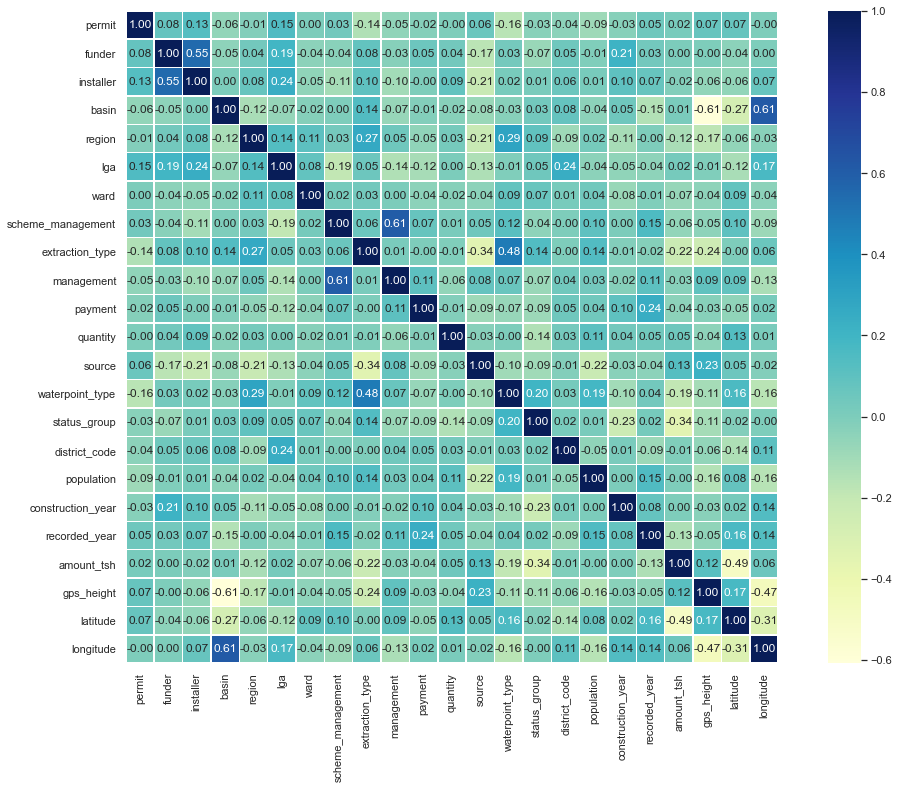

In [86]:
# can also use a different method
nw.correlations(df_mean,method='spearman')

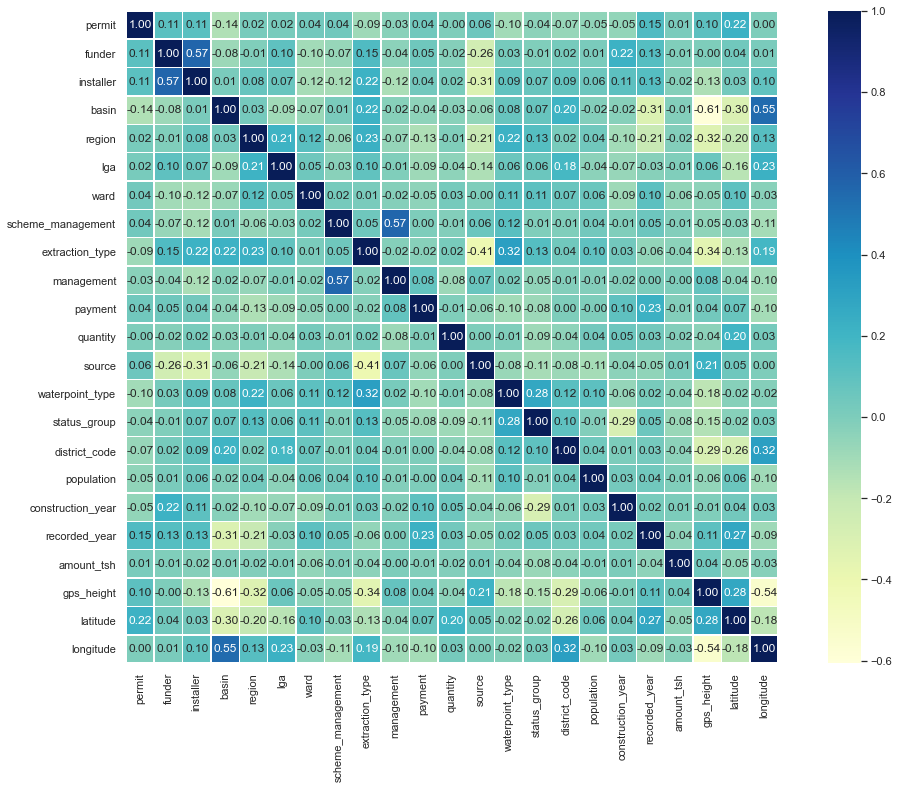

In [87]:
nw.correlations(df_nonzy)

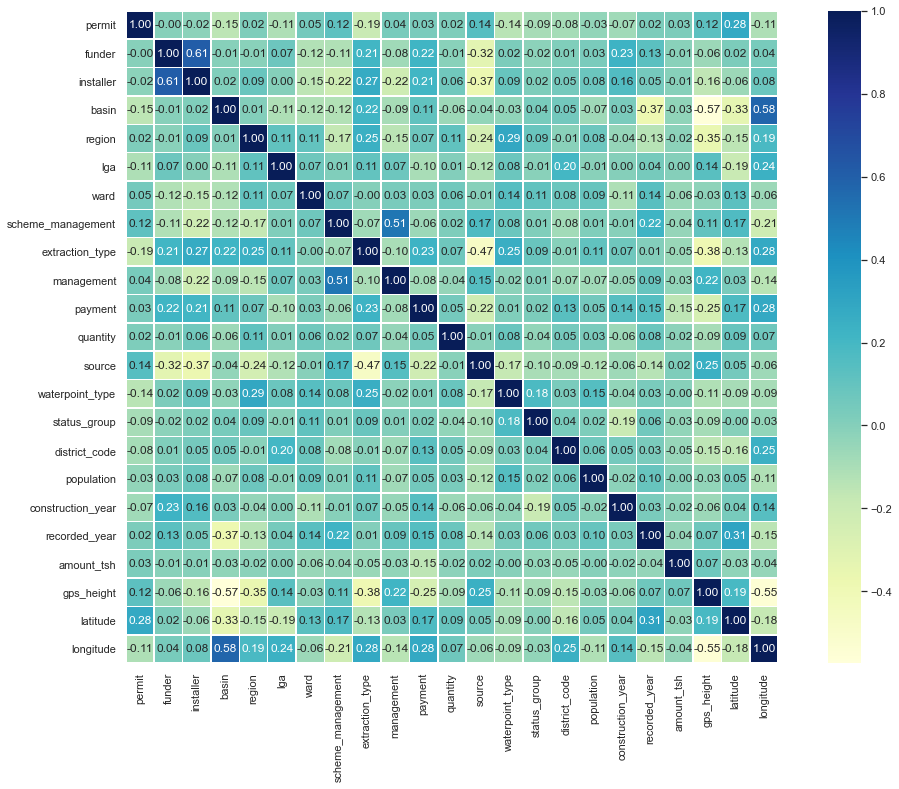

In [88]:
nw.correlations(df_reduced)

Using also a different correlation methods on the various dataframes confirms that there are no high correlations between the remaining features. Still, the method previously used for categorical features showed some possible correlations, so it may be necessary removing some other attributes.

In [158]:
# Save data to be used in the model and visualization
df_reduced.to_csv('data/processed/dfred.csv',index=False)
df_reduced_noenc.to_csv('data/processed/dfred_noenc.csv',index=False)
df_nonzy.to_csv('data/processed/dffilled.csv',index=False)
df_mean.to_csv('data/processed/dfmean.csv',index=False)
df_mean_noenc.to_csv('data/processed/dfmean_noenc.csv',index=False)

EXPLORATORY DATA ANALYSES

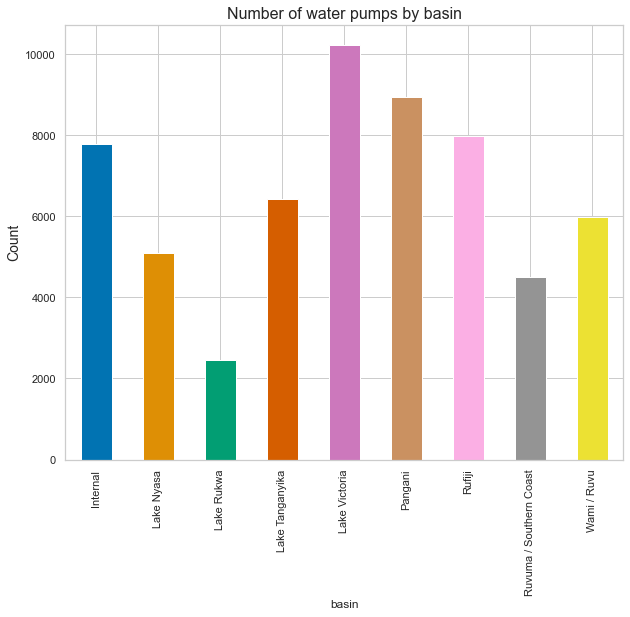

In [97]:
count_vs_basin = df_mean_noenc.groupby('basin')['status_group'].count().plot(kind='bar',color=bcol, 
                                                                             figsize=(10,8))
plt.title('Number of water pumps by basin',fontsize=16)
plt.ylabel('Count',fontsize=14)
fig1=count_vs_basin.get_figure()
#fig1.savefig('data/plots/count_vs_basin.png',bbox_inches='tight')

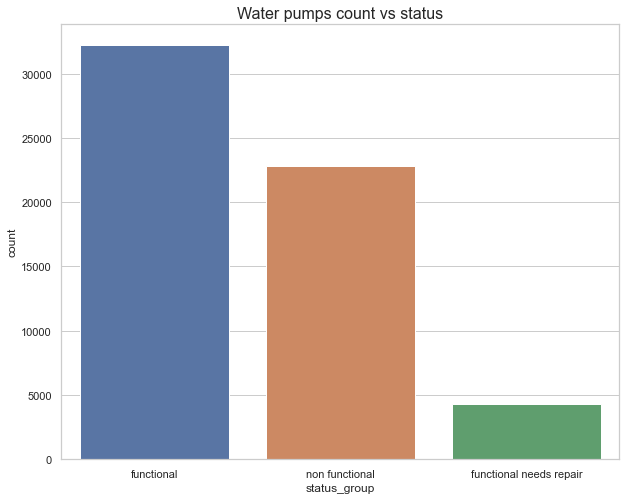

In [98]:
fig2, ax2 = plt.subplots(1, 1, figsize=(10,8))
sns.countplot(x="status_group", data=df_mean_noenc,ax=ax2)
ax2.set_title('Water pumps count vs status',fontsize=16)
plt.close(2)
#fig2.savefig('data/plots/count_vs_status.png',bbox_inches='tight')

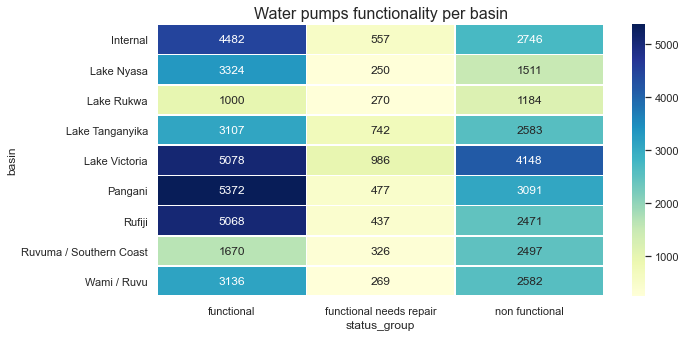

In [99]:
count_status_basin=status_basin_gr['amount_tsh'].count().unstack(level='status_group')
fig3,ax3=plt.subplots(1,1,figsize=(10,5))
sns.heatmap(count_status_basin,annot=True,fmt='d',cmap="YlGnBu",linewidths=0.5)
ax3.set_title('Water pumps functionality per basin',fontsize=16)
#fig3.savefig('data/plots/basin_vs_status.png',bbox_inches='tight')

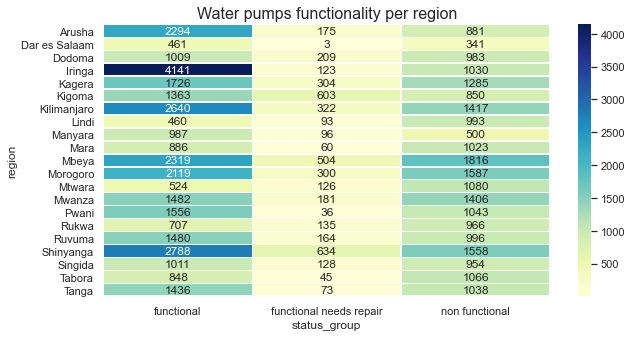

In [100]:
df_bas_stat=df_noenc[['region','status_group']].copy()
status_region_gr=df_bas_stat.groupby(['status_group','region'])
count_status_region=status_region_gr['status_group'].count().unstack(level='status_group')
fig4,ax4=plt.subplots(1,1,figsize=(10,5))
sns.heatmap(count_status_region,annot=True,fmt='d',cmap="YlGnBu",linewidths=0.5)
ax3.set_title('Water pumps functionality per basin',fontsize=16)
ax4.set_title('Water pumps functionality per region',fontsize=16)
#fig4.savefig('data/plots/region_vs_status.png',bbox_inches='tight')

The above plots show that the number of water pumps in a functional group is similar across the various basins. By region, there's more variation in the functional group.

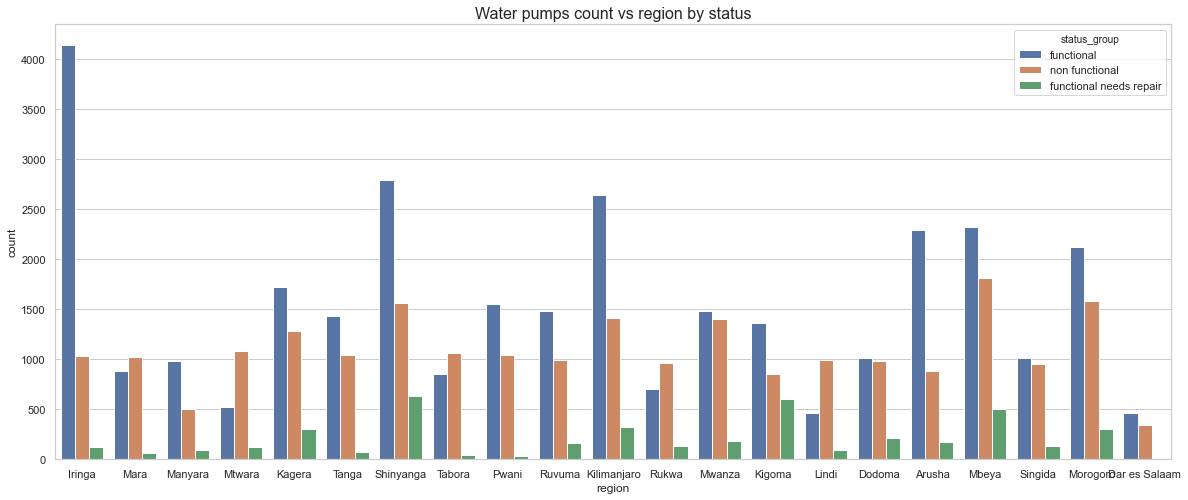

In [101]:
fig5, ax5 = plt.subplots(1, 1, figsize=(20,8))
sns.countplot(x="region", hue='status_group',data=df_mean_noenc, ax=ax5)
ax5.set_title('Water pumps count vs region by status',fontsize=16)
plt.close(2)
#fig5.savefig('data/plots/count_vs_region.png',bbox_inches='tight')

Most of the regions have functional pumps, but in some of them the non functional are the majority. This plot already suggests which regions are in higher need of repairs.

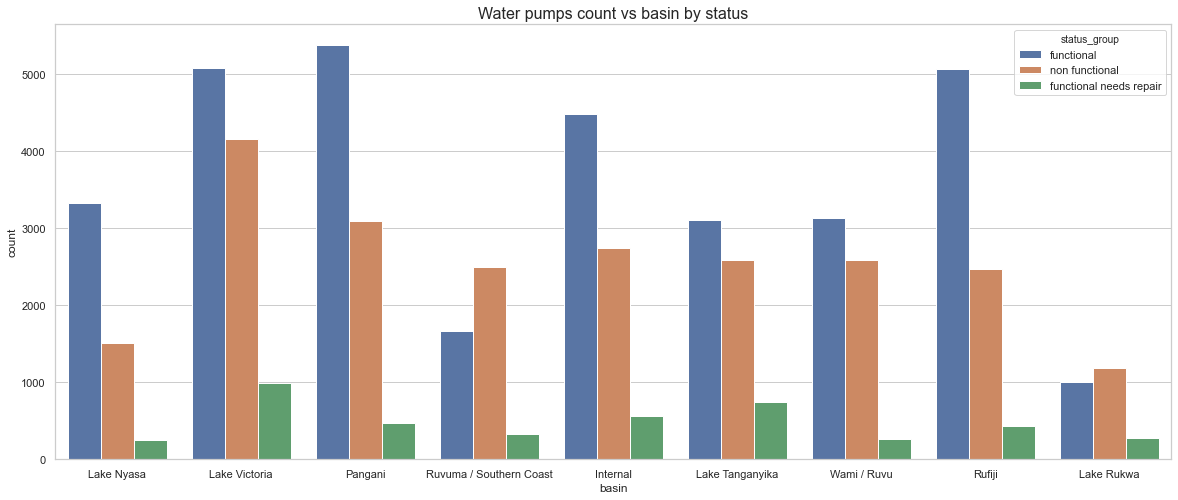

In [102]:
fig6, ax6 = plt.subplots(1, 1, figsize=(20,8))
sns.countplot(x="basin", hue='status_group',data=df_mean_noenc, ax=ax6)
ax6.set_title('Water pumps count vs basin by status',fontsize=16)
plt.close(2)
#fig6.savefig('data/plots/count_vs_basin1.png',bbox_inches='tight')

For the numerical variables, since the data is skewed, a log transformation can be used for better visualization. For the first two plots of population and amount of water, all the available data is used. For the third one, only the data with a known construction year is used.

In [103]:
df_log=df_mean[['population','amount_tsh']].copy().apply(np.log)

In [104]:
def plot_feature(dataFr,feature):
    
    fig,axs=plt.subplots(1,2,figsize=(10,5))
    plt.subplots_adjust(wspace=0.35)
    fig.suptitle('Box and histogram plots of {}'.format(feature),fontsize=16)
    fig.subplots_adjust(top=0.9)
    sns.boxplot(feature,data=dataFr,orient='v',ax=axs[0])
    axs[0].set_ylabel('')
    sns.distplot(dataFr[feature],bins=20,kde=False,ax=axs[1])
    axs[1].set_xlabel('')
    #fig.savefig('data/plots/{}.png'.format(feature),bbox_inches='tight')

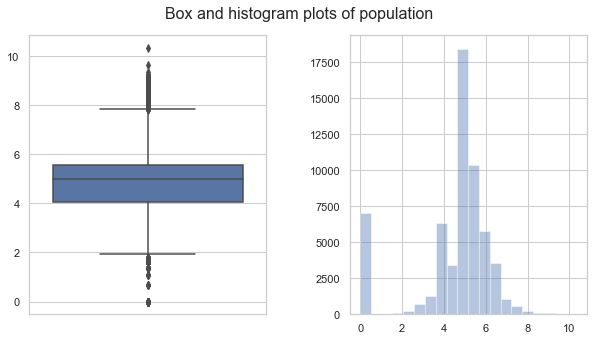

In [105]:
plot_feature(df_log,'population')

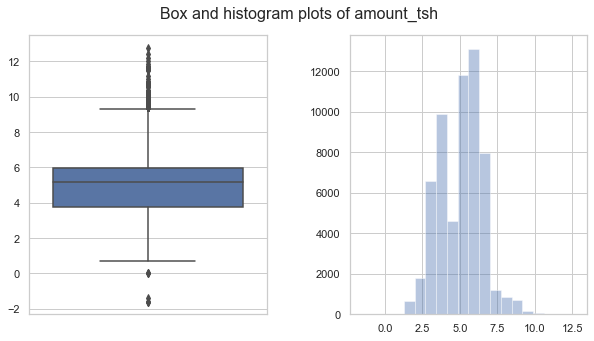

In [106]:
plot_feature(df_log,'amount_tsh')

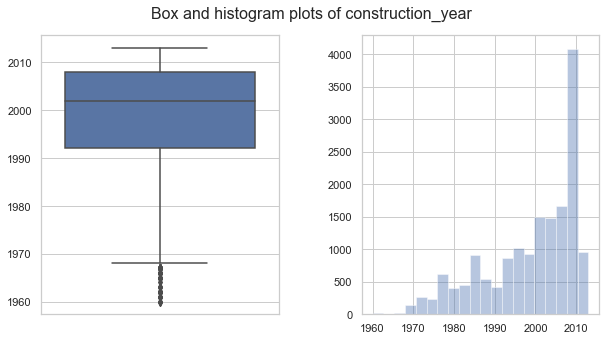

In [107]:
plot_feature(df_reduced,'construction_year')

The purpose of the next plots is to check how the water pumps' number and status has changed over the years.

In [109]:
status_list=dfy['status_group'].unique().tolist()

In [110]:
def pumps_vs_year(dataFr):
    
    group_by_year=dataFr.groupby(['construction_year','status_group'])['population']
    func_by_year=group_by_year.count().unstack(level='status_group').reset_index()
    
    # Check if there are missing values, i.e. in certain years a status might not be present.
    if func_by_year.isnull().sum().sum()!=0: func_by_year.fillna(0,inplace=True)
    func_by_year['Total']=func_by_year[status_list].apply(np.sum,axis=1)    
    
    fig,axs=plt.subplots(1,2,figsize=(12,5))
    plt.subplots_adjust(wspace=0.35)
    fig.suptitle('Number of water pumps over the years',fontsize=16)
    fig.subplots_adjust(top=0.9)
    sns.scatterplot(x='construction_year',y='Total',data=func_by_year,s=100,ax=axs[0])
    for status in status_list:
        sns.scatterplot(x='construction_year',y=status,data=func_by_year,label=status,s=100,ax=axs[1])
    axs[1].set_ylabel('')
    return fig
    #fig.savefig('Npumps_vs_years',bbox_inches='tight')

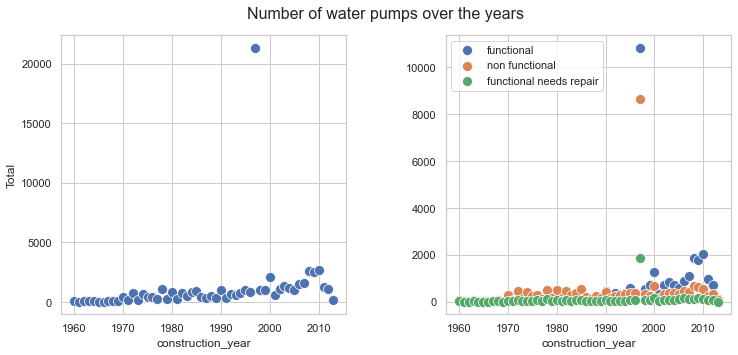

In [111]:
#pumps_vs_year(df_mean_noenc).savefig('data/plots/Npumps_vs_years',bbox_inches='tight')
pumps_vs_year(df_mean_noenc)

The dataframe with the mean value for the missing years has been used in the plot above. The same plot is repeated for the reduced dataframe, in which the trend isn't affected by the way the missing years information is filled in.

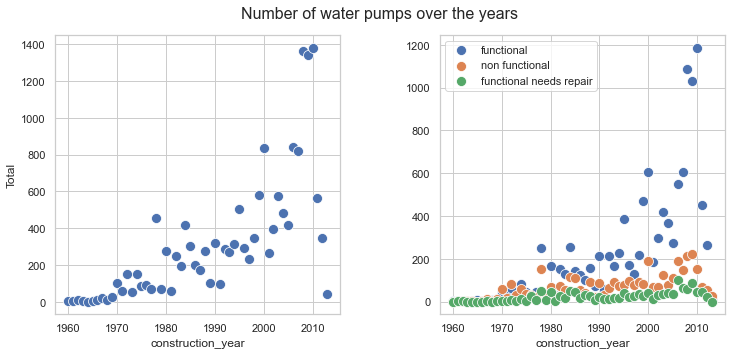

In [113]:
pumps_vs_year(df_reduced_noenc)
#pumps_vs_year(df_reduced_noenc).savefig('data/plots/Npumps_vs_years_red',bbox_inches='tight')

It looks like there has been an exponential growth of water pumps over the years, except for the last 4-5 years. They are also mostly functional, while the number of water pumps needing repair (and in part of those that are broken) has not followed the same trend; its hasn't change much. This might be an indication of a lack of maintenance for the broken once and that newest pumps tend to break less.

In [114]:
group_by_year1=df_reduced_noenc.groupby(['construction_year','basin'])['population'].count()
func_by_year1=group_by_year1.unstack(level='basin').reset_index()
if func_by_year1.isnull().sum().sum()!=0: func_by_year1.fillna(0,inplace=True)
basins_list=df_reduced_noenc['basin'].unique().tolist()
total_by_basin=func_by_year1[basins_list].sum(axis=0)
total_by_basin

basin
Lake Nyasa                  881.0
Pangani                    3452.0
Rufiji                     3652.0
Ruvuma / Southern Coast    1679.0
Wami / Ruvu                2730.0
Lake Tanganyika            1765.0
Internal                   1590.0
Lake Victoria               423.0
Lake Rukwa                  385.0
dtype: float64

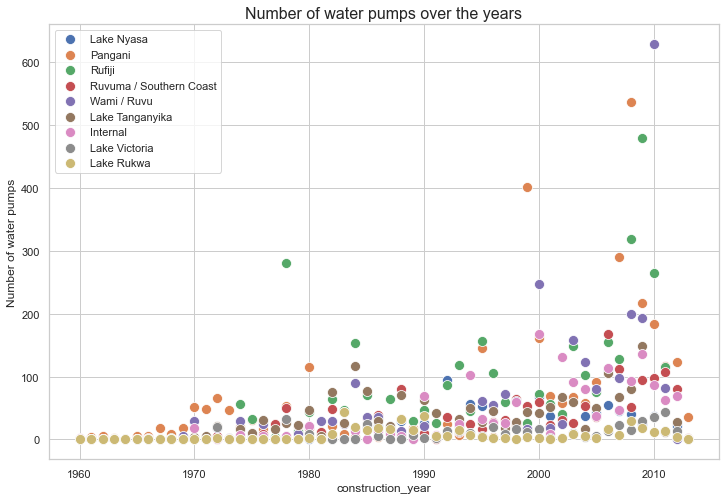

In [116]:
fig7,ax7=plt.subplots(1,1,figsize=(12,8))
ax7.set_title('Number of water pumps over the years',fontsize=16)

for basin in basins_list:
    sns.scatterplot(x='construction_year',y=basin,data=func_by_year1,label=basin,s=100,ax=ax7)
    ax7.set_ylabel('Number of water pumps')
#fig7.savefig('data/plots/Npumps_vs_years_basin.png',bbox_inches='tight')    

One last plot involves the recorded year, which is going to be used in survival analyses. 

Text(66.453125, 0.5, '')

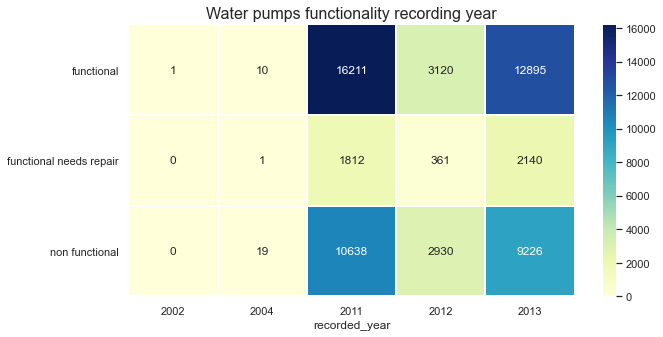

In [117]:
#status_year_gr=df_reduced_noenc.groupby(['status_group','recorded_year'])['status_group']
status_year_gr=df_mean_noenc.groupby(['status_group','recorded_year'])['status_group']
df_status_year=status_year_gr.count().unstack(level='recorded_year')
df_status_year.fillna(0,inplace=True)
df_status_year=df_status_year.astype(int)
fig8,ax8=plt.subplots(1,1,figsize=(10,5))
sns.heatmap(df_status_year,fmt='d',annot=True,cmap="YlGnBu",linewidths=1)
ax8.set_title('Water pumps functionality recording year',fontsize=16)
ax8.set_ylabel('')
#fig8.savefig('status_recyear.png',bbox_inches='tight')

SURVIVAL ANALYSES

For survival analyses, a time-to-event needs to be established. Here it is defined as the time between the construction year and the recorded year. Also the observed event needs to be defined. In this case, the classifier's labels can be used, since they indicate the water pumps' status.

In [118]:
# define some parameters that will be used (these are also the default values in the custom functions)
random=9 
spsize=0.3

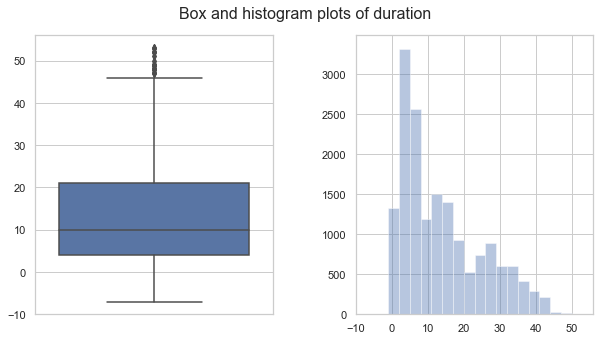

In [121]:
X,y=su.xy(df_reduced)
X.reset_index(drop=True)
y.reset_index(drop=True)
# define and plot duration 
X['duration']=X['recorded_year']-X['construction_year']
plot_feature(X,'duration')

The above plot shows that the median age of a water pump at the time of recording is 10 years, and for most of the water pumps it is between 4 and 21. Also, there are some negative values that will be dropped, since a negative duration doesn't make sense and they might indicate a wrong entry data.

To apply survival analyses, first a simple Kaplan-Meyer model is considered. This is based on only the duration information, or time to event, and the event (water pump is broken/needs repair, or it is functional).

In [122]:
E_all,T_all,_,_,_,_=su.surv_data(X,y)

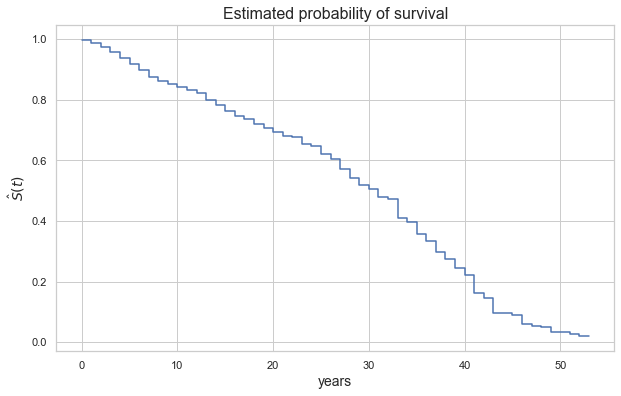

In [123]:
su.km(E_all,T_all)

The overall probability of survival, i.e. of the water pumps to be functional, changes slope around 25 and 40 years.
It is possible to visualize how it changes depending on some variables, for example the basin where the pumps are located and the water quantity.

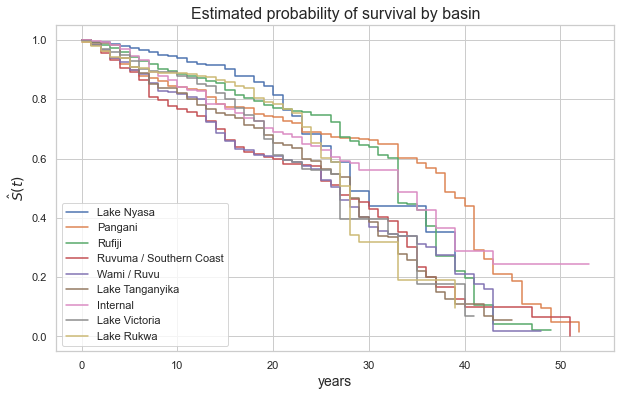

In [124]:
su.prob_vs_feature(df_reduced_noenc,'basin',E_all,T_all)

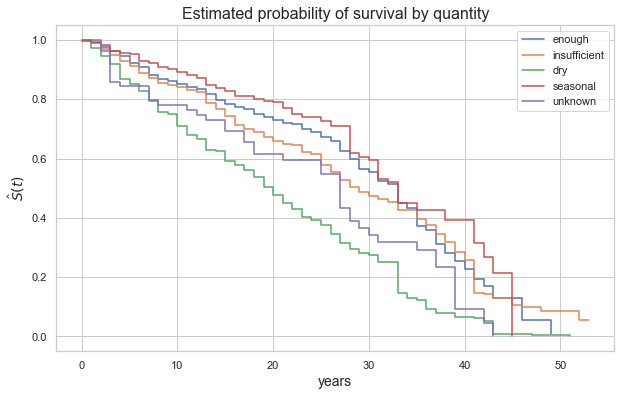

In [125]:
su.prob_vs_feature(df_reduced_noenc,'quantity',E_all,T_all)

When looking at the different basins and the water availability, the survival probability shows more variation. These observations can suggest some considerations when it comes to maintenance. For example, the conditions of the water pumps should be looked at separately for the variuos basins and also the amount of water should be considered as well.

From the modeling point of view, different algorithms can be tried, which allow to use more features and build more complex models.
Here, a Cox regression model and a Random Forest model applied to survival analyses are trained and compared. Also Support Vector Machine can be used, although it doesn't allow comparison of hazard function and survival prediction.
These models can be built using Scikit-survival package, which supports grid search. Also, the data has to be in a specific format, depending on the model. The needed transformation are done using custom functions applied to both train and test data.

In [126]:
Xg,yg=su.xy(df_reduced)
Xtrg,Xtstg,ytrg,ytstg=su.split_data(Xg,yg)
_,_,Xco_tr,yco_tr,Xrf_tr,yrf_tr=su.surv_data(Xtrg,ytrg)
_,_,Xco_ts,yco_ts,Xrf_ts,yrf_ts=su.surv_data(Xtstg,ytstg)

In [127]:
co_grid={"alpha": [0.01,0.1,0,1,10,100]}
base_co = CoxPHSurvivalAnalysis()
best_co=su.tune_model(base_co,Xco_tr,yco_tr,Xco_ts,yco_ts,co_grid)

Tuned Parameters: {'alpha': 1}

Training score: 0.629
Test score: 0.634


In [128]:
# coefficients for each feature
pd.Series(best_co.coef_, index=Xco_tr.columns)

permit              -0.355213
funder               0.028090
installer           -0.001962
basin                0.031326
region               0.016094
lga                 -0.017560
ward                 0.037114
scheme_management    0.030634
extraction_type      0.001319
management          -0.002578
payment              0.075785
quantity            -0.178621
source              -0.029421
waterpoint_type      0.104070
district_code        0.010177
population          -0.000184
amount_tsh          -0.000021
gps_height          -0.000293
latitude             0.019880
longitude           -0.066366
dtype: float64

In [129]:
svm_grid={"alpha": [0.01,0.1,1,10,100]}
base_svm=FastSurvivalSVM(optimizer="rbtree", max_iter=100, tol=1e-6, random_state=random)
base_svm=FastSurvivalSVM(max_iter=100, tol=1e-6, random_state=random)
best_svm=su.tune_model(base_svm,Xco_tr,yco_tr,Xco_ts,yco_ts,svm_grid)

Tuned Parameters: {'alpha': 0.01}

Training score: 0.583
Test score: 0.582


In [130]:
rfs_grid= {
    'min_samples_split': [10, 50], 
    'n_estimators' : [10,50],
    'min_samples_leaf': [5,15]}

base_rsf = RandomSurvivalForest(max_features="sqrt",
                           n_jobs=-1,
                           random_state=random)

best_rf=su.tune_model(base_rsf,Xrf_tr,yrf_tr,Xrf_ts,yrf_ts,rfs_grid)

Tuned Parameters: {'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}

Training score: 0.867
Test score: 0.797


Random Survival Forest has the best performance among the three models. Its prediction and hazard function can be compared to those of Cox. A random water pump can be chosen to make a prediction.

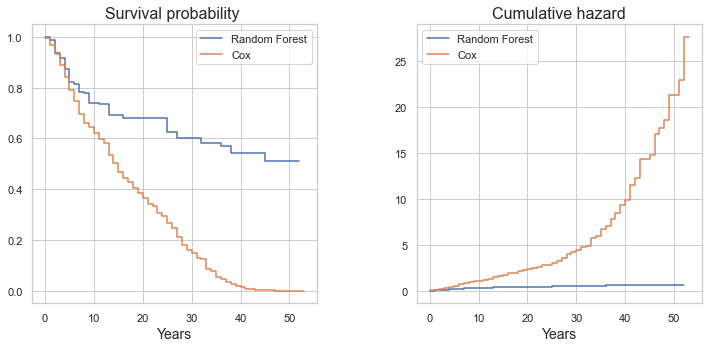

In [131]:
wp=4
rf_sur,rf_haz=su.rf_prediction(wp,best_rf,Xrf_tr)
co_sur,co_haz=su.cox_prediction(wp,best_co,Xco_tr)
su.plot_predictions(best_rf,rf_sur,rf_haz,co_sur,co_haz)

The difference between the models is evident from the above plots.

In [153]:
#saved_co = pickle.dumps(best_co) 
pickle.dump(best_co, open('src/artifacts/saved_co', 'wb'))

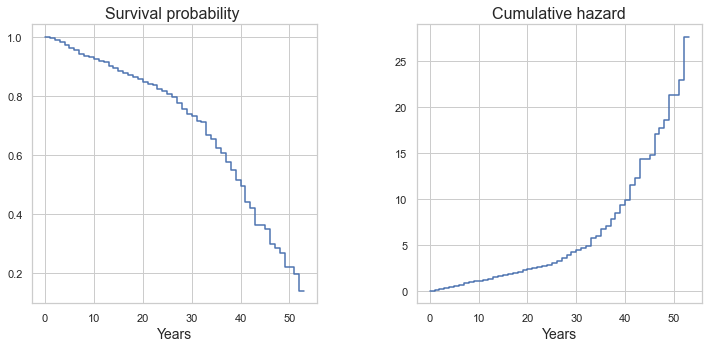

In [155]:
#loaded_co=pickle.loads(saved_co)
loaded_co=pickle.load(open('src/artifacts/saved_co', 'rb'))
sur5,haz5=su.cox_prediction(5,loaded_co,Xco_tr)
su.plot_cox_prediction(loaded_co,sur5,haz5)

In [156]:
#saved_rf = pickle.dumps(best_rf) 
pickle.dump(best_rf, open('src/artifacts/saved_rf', 'wb'))

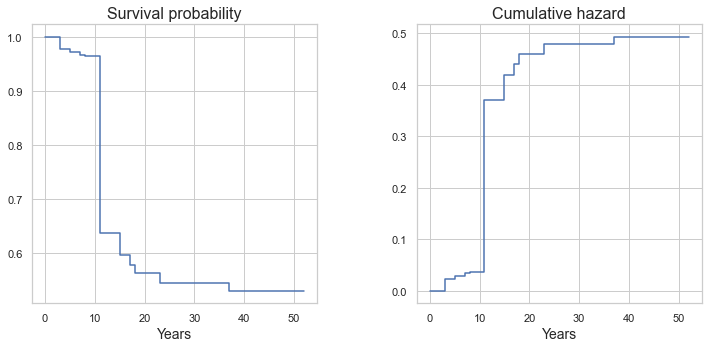

In [157]:
#loaded_rf=pickle.loads(saved_rf)
loaded_co=pickle.load(open('src/artifacts/saved_rf', 'rb'))
surf5,hazrf5=su.rf_prediction(5,loaded_rf,Xrf_tr)
su.plot_rf_prediction(loaded_rf,surf5,hazrf5)

To see if having more observations improves the models, the data that includes the transformed amount and population missing values is used.

In [132]:
# here I use more data
Xm,ym=su.xy(df_nonzy)
Xtrm,Xtstm,ytrm,ytstm=su.split_data(Xm,ym)
_,_,Xc_tr,yc_tr,Xr_tr,yr_tr=su.surv_data(Xtrm,ytrm)
_,_,Xc_ts,yc_ts,Xr_ts,yr_ts=su.surv_data(Xtstm,ytstm)

In [133]:
base_co_m = CoxPHSurvivalAnalysis()
best_co_m=su.tune_model(base_co_m,Xc_tr,yc_tr,Xc_ts,yc_ts,co_grid)

Tuned Parameters: {'alpha': 0}

Training score: 0.628
Test score: 0.627


In [160]:
base_rsf_m = RandomSurvivalForest(max_features="sqrt",
                           n_jobs=-1,
                           random_state=random)

best_rf_m=su.tune_model(base_rsf_m,Xr_tr,yr_tr,Xr_ts,yr_ts,rfs_grid)

Tuned Parameters: {'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}

Training score: 0.861
Test score: 0.828


In [161]:
# save models
pickle.dump(best_co_m, open('src/artifacts/saved_co_m', 'wb'))
pickle.dump(best_rf_m, open('src/artifacts/saved_rf_m', 'wb'))

With more data, the Random Survival Forest is improved, while Cox regression is more or less the same.